In [5]:
# https://datascienceplus.com/keras-regression-based-neural-networks/
# https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_04_3_regression.ipynb
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
# https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
# https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
# https://stackoverflow.com/questions/49008074/how-to-create-a-neural-network-for-regression
# https://www.pyimagesearch.com/2019/01/21/regression-with-keras/
# https://www.tensorflow.org/tutorials/keras/regression?hl=en
# https://keras.rstudio.com/articles/tutorial_basic_regression.html
# https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
# https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
# https://mydeeplearningnb.wordpress.com/2019/02/23/convnet-for-classification-of-cifar-10/

# https://www.omidrouhani.com/research/logisticregression/html/logisticregression.htm
# https://medium.com/@themantalope/glms-cpus-and-gpus-an-introduction-to-machine-learning-through-logistic-regression-python-and-3f226196b1db
# https://developer.nvidia.com/discover/logistic-regression

# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
# https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
# https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

# https://stackoverflow.com/questions/9622163/save-plot-to-image-file-instead-of-displaying-it-using-matplotlib
# https://peltarion.com/knowledge-center/documentation/evaluation-view/loss-and-metrics

# https://www.machinecurve.com/index.php/2019/10/12/using-huber-loss-in-keras/

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output
from livelossplot import PlotLossesKeras
from time import time
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.models import load_model

from ann_visualizer.visualize import ann_viz;
from keras.models import model_from_json

from keras_sequential_ascii import keras2ascii
from livelossplot import PlotLossesKeras

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

from keras.optimizers import SGD, Adam, RMSprop, Adagrad
import pickle

import os;
path="."
os.chdir(path)
os.getcwd()

# Variables
#dataset=np.loadtxt("dataset_MD.csv", delimiter=",")
# Let's consider a smaller dataset, up to 10000 K ...
dataset=np.loadtxt("../../data/dataset_MD_10000K.csv", delimiter=",")
x=dataset[:,0:4]
y=dataset[:,4] # 0: X, 1: T, 2: I, 3: J, 4: MD (mass diffusion)

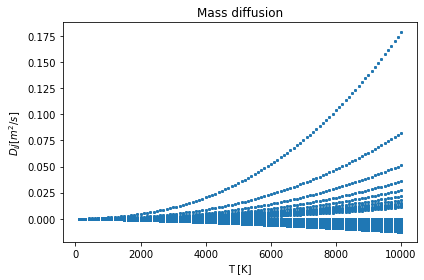

In [12]:
# 2D Plot
plt.scatter(x[:,1], dataset[:,4], s=0.5)
plt.title('Mass diffusion')
plt.xlabel('T [K]')
plt.ylabel(r'$D_ij$ $[m^2/s]$')
plt.tight_layout()
plt.savefig("mass_diffusion.pdf")
plt.show()

# 3D Plot
#fig = plt.figure()
#ax = Axes3D(fig)
#ax.scatter(x[:,0], x[:,1], dataset[:,4], s=0.5)
#ax.set_xlabel('molar fraction', fontsize=20, rotation=150)
#ax.set_ylabel('T [K]')
# disable auto rotation
#ax.zaxis.set_rotate_label(False) 
#ax.set_zlabel(r'$D_ij [m^2/s]$', fontsize=30, rotation = 0)
#plt.show()

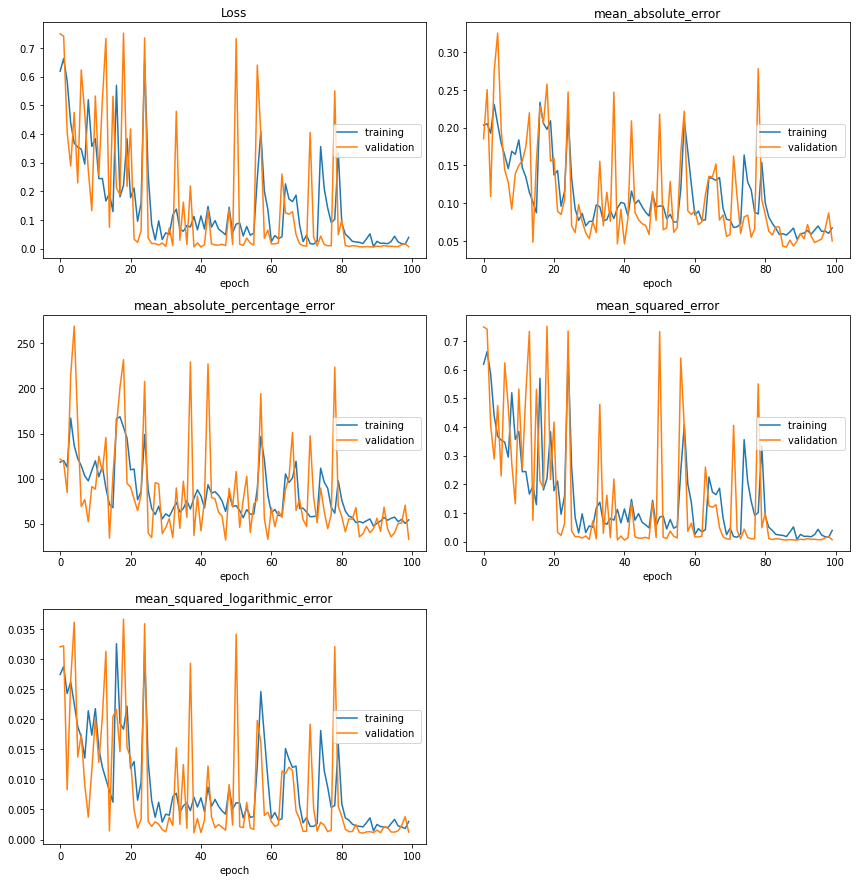

Loss
	training         	 (min:    0.007, max:    0.663, cur:    0.039)
	validation       	 (min:    0.006, max:    0.752, cur:    0.007)
mean_absolute_error
	training         	 (min:    0.052, max:    0.234, cur:    0.067)
	validation       	 (min:    0.042, max:    0.325, cur:    0.050)
mean_absolute_percentage_error
	training         	 (min:   47.304, max:  168.567, cur:   54.192)
	validation       	 (min:   31.829, max:  269.028, cur:   32.749)
mean_squared_error
	training         	 (min:    0.007, max:    0.663, cur:    0.039)
	validation       	 (min:    0.006, max:    0.752, cur:    0.007)
mean_squared_logarithmic_error
	training         	 (min:    0.001, max:    0.033, cur:    0.003)
	validation       	 (min:    0.001, max:    0.037, cur:    0.001)
2112880/2112880 - 26s - loss: 0.0394 - mean_squared_error: 0.0394 - mean_absolute_error: 0.0672 - mean_absolute_percentage_error: 54.1922 - mean_squared_logarithmic_error: 0.0030 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - v

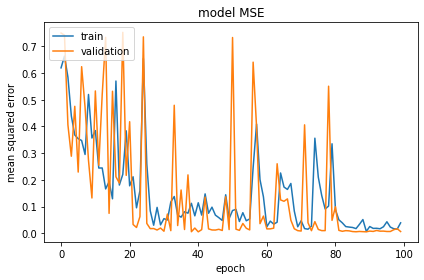

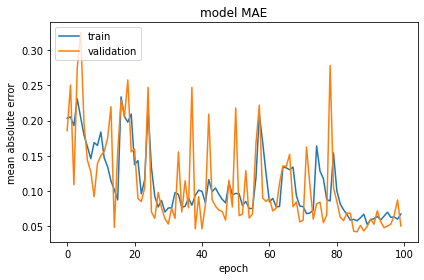

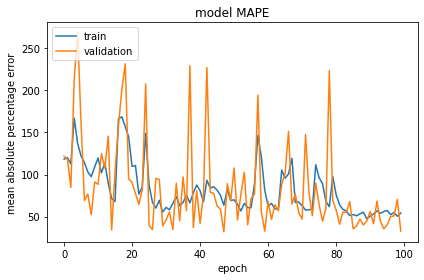

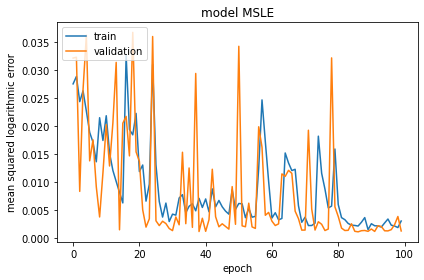

[INFO] predicting...
Final score (MSE): 0.006906599197737134
Final score (MAE): 0.05003333164447411
Final score (RMSE): 0.08310595163847855


In [7]:
# Implementing a NN, it is beneficial to normalize the variables.
# Therefore, variables are transformed using the MaxMinScaler().
print("[INFO] Scaling data...")
y=np.reshape(y, (-1,1))
#scaler_x = MinMaxScaler() #StandardScaler() #RobustScaler() #MaxAbsScaler()
#scaler_y = MinMaxScaler()
scaler_x = StandardScaler() #RobustScaler() #MaxAbsScaler()
scaler_y = StandardScaler()
print(scaler_x.fit(x))
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))
yscale=scaler_y.transform(y)

# The data is then split into training and test data
# Let's use 20% of original data for testing
# The random_state is just for reproducibility (see function doc)
print("[INFO] constructing training/testing split...")
#X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2, random_state=42)

model = Sequential()

# Usually it's a good practice to apply following formula in order to find out the total number of hidden layers needed.
#
# Nh = Ns/(α∗ (Ni + No))
#
# where
#
#    Ni = number of input neurons.
#    No = number of output neurons.
#    Ns = number of samples in training data set.
#    α = an arbitrary scaling factor usually 2-10.
#
# ... but I don't care and I take random number of layers and neurons per layer,
# then manually tune the NN.

model.add(Dense(10, input_dim=4, kernel_initializer='normal', activation='relu')) # Hidden 1

# https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
# dropout in the input layer with weight constraint
#model.add(Dropout(0.2, input_shape=(60,)))

#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2

# dropout in hidden layers with weight constraint
#model.add(Dropout(0.2))

model.add(Dense(30, kernel_initializer='normal', activation='relu'))              # Hidden 2
model.add(Dense(30, kernel_initializer='normal', activation='relu'))              # Hidden 2
model.add(Dense(30, kernel_initializer='normal', activation='relu'))              # Hidden 2
model.add(Dense(30, kernel_initializer='normal', activation='relu'))              # Hidden 2
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2
model.add(Dense(1, activation='linear'))                                            # Output

# https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
# lrate = initial_lrate * (1 / (1 + decay * iteration))
#opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01)
opt = keras.optimizers.Adam(learning_rate=0.01)

model.summary()

keras2ascii(model)

# monitor the learning rate
#class LearningRateMonitor(Callback):
#	# start of training
#	def on_train_begin(self, logs={}):
#		self.lrates = list()
#
#	# end of each training epoch
#	def on_epoch_end(self, epoch, logs={}):
#		# get and store the learning rate
#		optimizer = self.model.optimizer
#		lrate = float(backend.get_value(self.model.optimizer.lr))
#		self.lrates.append(lrate)
        
# Drop Learning Rate on Plateau
#rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_delta=1E-7)
#lrm = LearningRateMonitor()

# mse:  loss = square(y_true - y_pred)
# mae:  loss = abs(y_true - y_pred)
# mape: loss = 100 * abs(y_true - y_pred) / y_true
# msle: loss = square(log(y_true + 1.) - log(y_pred + 1.))
model.compile(loss='mse', metrics=['mse', 'mae', 'mape', 'msle'], optimizer=opt)

#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Train model
# The validation_split set to 0.2, 80% of the training data is used to test the model, while the remaining 20% is used for testing.
#
# one epoch = one forward pass and one backward pass of all the training examples
#
# batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space.
#
# number of iterations = number of passes, each pass using [batch size] number of examples.
# One pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
#
# The batch size defines the number of samples that will be propagated through the network.
#
# Advantages of using a batch size < number of all samples:
#
# * It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory.
#   That's especially important if you are not able to fit the whole dataset in your machine's memory.
#
# * Typically networks train faster with mini-batches. That's because we update the weights after each propagation.
#
# Disadvantages of using a batch size < number of all samples:
#
# * The smaller the batch the less accurate the estimate of the gradient will be.

print("[INFO] training model...")
# Since the dataset_MD file contains 2641100 items is convenient to set batch_size = 343 or 2401 to be divisible
#history = model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2, validation_split=0.2)
#history = model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2, validation_split=0.2, callbacks=[plot_losses])
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[monitor], verbose=2, batch_size=50, epochs=100)
history = model.fit(X_train, y_train, epochs=100, batch_size=343, verbose=2, validation_data=(X_test, y_test), callbacks=[PlotLossesKeras()])

#loss_history = np.array(history)
#np.savetxt("loss_history.txt", loss_history, delimiter=",")

# Plot metrics
print(history.history.keys())

# "Loss"
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MSE.pdf", dpi=150)
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MAE.pdf", dpi=150)
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model MAPE')
plt.ylabel('mean absolute percentage error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MAPE.pdf", dpi=150)
plt.show()

plt.figure()
plt.plot(history.history['mean_squared_logarithmic_error'])
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('model MSLE')
plt.ylabel('mean squared logarithmic error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MSLE.pdf", dpi=150)
plt.show()

# Predict
print("[INFO] predicting...")
pred = model.predict(X_test)

score = metrics.mean_squared_error(pred, y_test)
print("Final score (MSE): {}".format(score))

score = metrics.mean_absolute_error(pred, y_test)
print("Final score (MAE): {}".format(score))

# Measure RMSE error. RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Final score (RMSE): {}".format(score))

def print_metrics(y_test, y_pred):
    print("RMSE: %.4f" % sqrt(mean_squared_error(y_test, pred)))
    print('Variance score: %.4f' % r2_score(y_test, pred))
    print('Explained variance score: %.4f' % explained_variance_score(y_test, pred))
    forecast_err = np.array(y_test) - np.array(pred)    

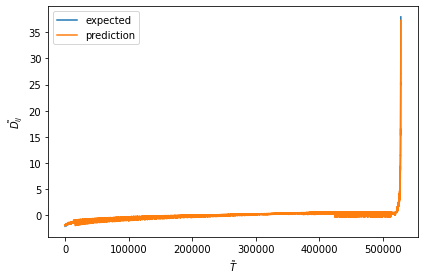

X=[9.e-01 1.e+03 9.e+00 1.e+01], Predicted=[-0.00013816]
X=[9.e-01 2.e+03 9.e+00 1.e+01], Predicted=[-6.859454e-05]
X=[9.e-01 3.e+03 9.e+00 1.e+01], Predicted=[-0.00044008]
X=[9.e-01 4.e+03 9.e+00 1.e+01], Predicted=[-0.00103185]
X=[9.e-01 5.e+03 9.e+00 1.e+01], Predicted=[-0.00162362]
X=[9.e-01 6.e+03 9.e+00 1.e+01], Predicted=[-0.00221538]
X=[9.e-01 7.e+03 9.e+00 1.e+01], Predicted=[-0.00280714]
X=[9.e-01 8.e+03 9.e+00 1.e+01], Predicted=[-0.00339891]
X=[9.e-01 9.e+03 9.e+00 1.e+01], Predicted=[-0.00399067]
X=[9.e-01 1.e+04 9.e+00 1.e+01], Predicted=[-0.00458245]
0.9 1000.0 9.0 10.0 [-0.00014855]
0.9 2000.0 9.0 10.0 [-0.00042018]
0.9 3000.0 9.0 10.0 [-0.00077191]
0.9 4000.0 9.0 10.0 [-0.00118844]
0.9 5000.0 9.0 10.0 [-0.00166089]
0.9 6000.0 9.0 10.0 [-0.0021833]
0.9 7000.0 9.0 10.0 [-0.00275127]
0.9 8000.0 9.0 10.0 [-0.00336141]
0.9 9000.0 9.0 10.0 [-0.00401098]
0.9 10000.0 9.0 10.0 [-0.00469772]


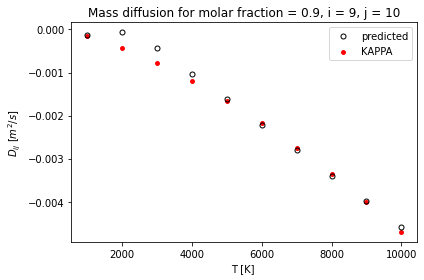

In [11]:
with open('./history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
#history = pickle.load(open('/history'), "rb")        
        
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel(r'$\tilde{D_{ij}}$')
    plt.xlabel(r'$\tilde{T}$')
    plt.legend()
    plt.tight_layout()
    plt.savefig("adim_regression.pdf", dpi=150)
    plt.show()

# Plot the chart
chart_regression(pred.flatten(), y_test)

# Pick up a single value ...
# 0.9, 9000, 35, 15, -0.00401098189571194585
#Xnew = np.array([[0.9, 9000, 15, 48]])
#Xnew = np.array([[0.9, 1000,  9, 10], [0.9, 5000, 9, 10],  [0.9, 10000, 9, 10], [0.9, 15000, 9, 10], 
#                 [0.9, 20000, 9, 10], [0.9, 25000, 9, 10], [0.9, 30000, 9, 10], [0.9, 35000, 9, 10],
#                 [0.9, 40000, 9, 10]])

Xnew = np.array([[0.9, 1000, 9, 10], [0.9, 2000,  9, 10], [0.9, 3000, 9, 10], [0.9, 4000, 9, 10], 
                 [0.9, 5000, 9, 10], [0.9, 6000,  9, 10], [0.9, 7000, 9, 10], [0.9, 8000, 9, 10],
                 [0.9, 9000, 9, 10], [0.9, 10000, 9, 10]])

Xnew = scaler_x.transform(Xnew)
ynew = model.predict(Xnew)

# Invert normalize
ynew = scaler_y.inverse_transform(ynew)
Xnew = scaler_x.inverse_transform(Xnew)
# show the inputs and predicted outputs
for i in range(len(Xnew)):
    print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))

print(x[2182960,0],x[2182960,1],x[2182960,2],x[2182960,3],y[2182960]) #0.9 1000.0 9.0 10.0, -0.00014855
print(x[2206970,0],x[2206970,1],x[2206970,2],x[2206970,3],y[2206970]) #0.9 2000.0 9.0 10.0, -0.00042018
print(x[2230980,0],x[2230980,1],x[2230980,2],x[2230980,3],y[2230980]) #0.9 3000.0 9.0 10.0, -0.00077191
print(x[2254990,0],x[2254990,1],x[2254990,2],x[2254990,3],y[2254990]) #0.9 4000.0 9.0 10.0, -0.00118844
print(x[2279000,0],x[2279000,1],x[2279000,2],x[2279000,3],y[2279000]) #0.9 5000.0 9.0 10.0, -0.00166089
print(x[2303010,0],x[2303010,1],x[2303010,2],x[2303010,3],y[2303010]) #0.9 6000.0 9.0 10.0, -0.0021833
print(x[2327020,0],x[2327020,1],x[2327020,2],x[2327020,3],y[2327020]) #0.9 7000.0 9.0 10.0, -0.00275127
print(x[2351030,0],x[2351030,1],x[2351030,2],x[2351030,3],y[2351030]) #0.9 8000.0 9.0 10.0, -0.00336141
print(x[2375040,0],x[2375040,1],x[2375040,2],x[2375040,3],y[2375040]) #0.9 9000.0 9.0 10.0, -0.00401098
print(x[2399050,0],x[2399050,1],x[2399050,2],x[2399050,3],y[2399050]) #0.9 10000.0 9.0 10.0,-0.00469772

#plt.scatter(x[2374591:2376991,3], y[2374591:2376991], s=0.5, label='KAPPA')
plt.scatter(x[2182960,1], y[2182960], s=15, facecolor='red', label='KAPPA') # 1000
plt.scatter(x[2206970,1], y[2206970], s=15, facecolor='red')                # 2000
plt.scatter(x[2230980,1], y[2230980], s=15, facecolor='red')                # 3000
plt.scatter(x[2254990,1], y[2254990], s=15, facecolor='red')                # 4000
plt.scatter(x[2399050,1], y[2399050], s=15, facecolor='red')                # 5000
plt.scatter(x[2303010,1], y[2303010], s=15, facecolor='red')                # 6000
plt.scatter(x[2327020,1], y[2327020], s=15, facecolor='red')                # 7000
plt.scatter(x[2351030,1], y[2351030], s=15, facecolor='red')                # 8000
plt.scatter(x[2375040,1], y[2375040], s=15, facecolor='red')                # 9000
plt.scatter(x[2279000,1], y[2279000], s=15, facecolor='red')                # 10000

#plt.plot(x[2376321,1], ynew[0], 'o', color='black')
plt.plot(Xnew[:,1], ynew[:], 'o', color='black', label='predicted', linewidth=2, markersize=5, fillstyle='none')
plt.title('Mass diffusion for molar fraction = 0.9, i = 9, j = 10')
plt.ylabel(r'$D_{ij}$ $[m^2/s]$')
plt.xlabel('T [K] ')
plt.legend()
plt.tight_layout()
plt.savefig("dim_regression.pdf", dpi=150, crop='false')
plt.show()